In [ ]:
import warnings
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
from gensim.models import KeyedVectors
from gensim.models import FastText
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir_path = '/content/drive/MyDrive/ML Project/data/'
train_featured = pd.read_csv(data_dir_path + 'train_X_y_features_v1.csv')
test_featured = pd.read_csv( data_dir_path + 'test_X_y_features_v1.csv')
print(train_featured.shape)
print(test_featured.shape)

(1202739, 43)
(300685, 43)


In [ ]:
# Tabluar features
train_X = train_featured.drop(['title','description', 'item_id', 'user_id', 'item_seq_number', 'activation_date', 'image',
       'image_top_1', 'deal_probability'], axis=1)
test_X = test_featured.drop(['title','description', 'item_id', 'user_id', 'item_seq_number', 'activation_date', 'image',
       'image_top_1', 'deal_probability'], axis=1)
train_y = train_featured['deal_probability']
test_y = test_featured['deal_probability']

# Extract embeddings

In [ ]:
# train
train_featured['title'] = train_featured['title'].fillna("")
train_featured['description'] = train_featured['description'].fillna("")
train_featured['text'] = train_featured['title'] + " " + train_featured['description']
train_featured['tokenized_text'] = train_featured['text'].apply(lambda x: x.lower().split())



In [ ]:

# fasttext_model = FastText(
#     sentences=train_featured['tokenized_text'],
#     vector_size=100,
#     window=5,
#     min_count=2,
#     epochs=10
# )

In [ ]:
# fasttext_model.save(data_dir_path+"fasttext_russian_model.bin")

In [ ]:
fasttext_model = FastText.load(data_dir_path+"fasttext_russian_model.bin")

In [ ]:
def get_sentence_vector(model, sentence):
    """根据每个句子的单词生成句向量"""
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)  # 平均值作为句向量
    else:
        return np.zeros(model.vector_size)  # 如果没有匹配单词，则返回零向量


In [ ]:
X_train_only_embeddings = np.array([get_sentence_vector(fasttext_model, text) for text in train_featured['tokenized_text']])


In [ ]:
X_train_only_embeddings

array([[ 2.7390184 , -2.74321   , -1.4860431 , ...,  1.9490415 ,
         1.6414331 ,  0.67559355],
       [ 2.528935  , -1.6971284 , -0.5366932 , ...,  0.47865635,
         1.6347014 ,  1.9882907 ],
       [ 0.7860642 , -0.5535616 , -0.27576053, ..., -0.27145186,
         2.4926882 , -0.1730389 ],
       ...,
       [ 0.49970433, -0.7586271 , -1.8393654 , ...,  0.45273915,
         2.6143413 , -0.10480504],
       [ 2.115905  , -2.8628087 , -2.0563724 , ...,  2.5217528 ,
         1.2457689 ,  0.30688527],
       [ 0.91337067, -0.42092705,  0.770599  , ..., -1.7243596 ,
         4.4350963 , -0.6861565 ]], dtype=float32)

In [ ]:
# train
test_featured['title'] = test_featured['title'].fillna("")
test_featured['description'] = test_featured['description'].fillna("")
test_featured['text'] = test_featured['title'] + " " + test_featured['description']
test_featured['tokenized_text'] = test_featured['text'].apply(lambda x: x.lower().split())



In [ ]:
X_test_only_embeddings = np.array([get_sentence_vector(fasttext_model, text) for text in test_featured['tokenized_text']])


In [ ]:
def fit_lgb(
        train_X, train_y, test_X, test_y, categorical_features,
        params=None,
        num_boost_round=1000,
        early_stopping_rounds=50,
        eval_period=20,
    ):

    if params is None:
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'learning_rate': 0.02,
            'num_leaves': 512,
            'max_depth': 20,

            'bagging_seed': 42,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'feature_fraction': 0.8,
            'lambda_l1': 2.25,
            'lambda_l2': 0.015,

            'verbose': -1
        }

    # label encoding for cat var
    for col in categorical_features:
        train_X[col] = train_X[col].astype('category')
        test_X[col] = test_X[col].astype('category')

    # validation set for early stopping
    train_X_split, val_X_split, train_y_split, val_y_split = train_test_split(
        train_X, train_y, test_size=0.2, random_state=42, shuffle=True
    )
    lgb_train = lgb.Dataset(
        train_X_split, label=train_y_split, categorical_feature=categorical_features
    )
    lgb_val = lgb.Dataset(
        val_X_split, label=val_y_split, categorical_feature=categorical_features,
        reference=lgb_train
    )

    callbacks = [
        lgb.early_stopping(stopping_rounds=early_stopping_rounds),
        lgb.log_evaluation(period=eval_period)
    ]

    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=num_boost_round,
        valid_sets=[lgb_train, lgb_val],
        callbacks=callbacks
    )

    preds = model.predict(test_X, num_iteration=model.best_iteration)
    rmse = mean_squared_error(test_y, preds, squared=False)
    print(f"RMSE: {rmse}")

    return model

# LightGBM- Only embeddings 100


In [ ]:
X_train_only_embeddings.shape

(1202739, 100)

In [ ]:
model_1 = fit_lgb(X_train_only_embeddings, train_y, X_test_only_embeddings, test_y, [])


Training until validation scores don't improve for 50 rounds
[20]	training's rmse: 0.250726	valid_1's rmse: 0.252942
[40]	training's rmse: 0.245045	valid_1's rmse: 0.248157
[60]	training's rmse: 0.241259	valid_1's rmse: 0.245243
[80]	training's rmse: 0.238533	valid_1's rmse: 0.243373
[100]	training's rmse: 0.236421	valid_1's rmse: 0.242128
[120]	training's rmse: 0.234689	valid_1's rmse: 0.241238
[140]	training's rmse: 0.233191	valid_1's rmse: 0.240565
[160]	training's rmse: 0.231853	valid_1's rmse: 0.240053
[180]	training's rmse: 0.230653	valid_1's rmse: 0.239658
[200]	training's rmse: 0.229519	valid_1's rmse: 0.239313
[220]	training's rmse: 0.228473	valid_1's rmse: 0.239032
[240]	training's rmse: 0.227467	valid_1's rmse: 0.238788
[260]	training's rmse: 0.226517	valid_1's rmse: 0.238583
[280]	training's rmse: 0.2256	valid_1's rmse: 0.238391
[300]	training's rmse: 0.224719	valid_1's rmse: 0.238232
[320]	training's rmse: 0.223854	valid_1's rmse: 0.238087
[340]	training's rmse: 0.223009	v

# LightGBM = Embedding with SVD-42d


In [ ]:
svd = TruncatedSVD(n_components=42, random_state=42)  # reduce dimension to 5d
svd_matrix = svd.fit_transform(X_train_only_embeddings)
print("SVD matrix shape:", svd_matrix.shape)
fasttext_features_train = pd.DataFrame(svd_matrix, columns=[f'svd_{i}' for i in range(42)])

SVD matrix shape: (1202739, 42)


In [ ]:
fasttext_features_train

,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,...,svd_32,svd_33,svd_34,svd_35,svd_36,svd_37,svd_38,svd_39,svd_40,svd_41
0,18.712120,1.665349,-0.316207,-0.865870,1.004217,-4.422844,-1.784763,0.819020,-0.985039,1.135070,...,-0.590956,-1.087211,-0.799874,-1.122621,1.701886,-0.252314,1.493885,-0.257374,-1.266095,0.891860
1,17.063452,-5.314239,-0.158923,0.593008,1.314238,-1.136343,2.142924,0.214027,1.785138,1.298605,...,0.172983,-0.187748,-0.891440,0.491830,-0.566420,-0.542912,-0.598151,-0.369308,-0.956708,0.502890
2,8.301052,1.407741,-1.524526,4.494483,-0.058221,-0.944867,0.073577,0.157553,-0.158414,-0.344262,...,-1.212741,0.183845,0.383880,0.432686,-0.552630,0.748625,-0.447899,-0.383560,-0.415854,-0.177809
3,13.366659,-0.316903,4.525409,-2.305177,-0.898954,2.448828,-1.329531,1.810665,-0.934800,-0.744163,...,-0.095292,-0.399213,-1.308965,0.644886,1.579159,-0.561028,-0.379097,0.323405,0.223288,0.062198
4,13.153263,5.237125,-10.867508,0.831236,-3.664208,2.993702,1.709104,-0.997776,-2.356902,-4.754645,...,-0.235615,-0.602194,0.059004,1.343861,-0.908024,0.582427,-0.212719,0.209566,-0.100444,0.424449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202734,11.927881,6.155726,-3.977766,2.949713,2.087063,-2.669618,3.016116,2.066788,-1.070010,0.305451,...,6.839081,0.687795,-3.202302,-0.178912,-0.104948,-0.515421,1.246996,0.772102,-1.687494,1.114167
1202735,13.597333,5.843094,0.717789,-6.002838,5.886590,-0.057484,1.508186,1.862631,-0.875619,-1.013312,...,0.844168,0.034772,0.269135,-0.155830,0.859433,0.549835,-0.399183,0.399499,0.227667,-0.012890
1202736,12.830471,7.033854,-2.242913,6.332953,1.214504,-1.515098,2.900787,1.262639,0.700818,0.622122,...,-0.302642,1.104279,-0.890172,1.039392,0.433664,-0.424274,-0.754427,-1.486754,0.211968,-0.159443
1202737,15.792901,3.049137,3.662473,1.958672,-2.121026,-1.705861,0.289672,-0.145055,0.192149,1.002392,...,0.478689,-0.994210,1.299318,-0.486527,1.627801,-1.688751,1.098206,0.748161,0.059967,0.246059


In [ ]:
svd = TruncatedSVD(n_components=42, random_state=42)  # reduce dimension to 5d
svd_matrix_test = svd.fit_transform(X_test_only_embeddings)
print("SVD matrix shape:", svd_matrix_test.shape)
fasttext_features_test = pd.DataFrame(svd_matrix_test, columns=[f'svd_{i}' for i in range(42)])

SVD matrix shape: (300685, 42)


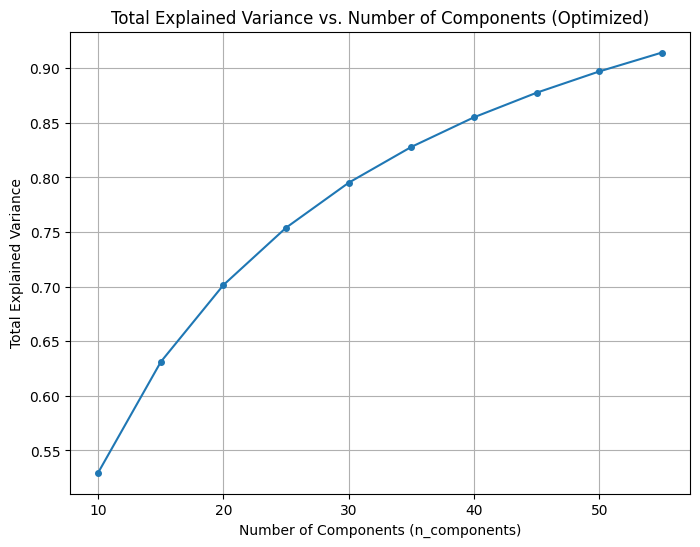

In [ ]:
explained_variances = []
n_components_range = range(10, 60, 5)
for n_components in n_components_range:
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    svd.fit(X_test_only_embeddings)
    explained_variances.append(svd.explained_variance_ratio_.sum())

plt.figure(figsize=(8, 6))
plt.plot(n_components_range, explained_variances, marker='o', linestyle='-', markersize=4)
plt.title("Total Explained Variance vs. Number of Components (Optimized)")
plt.xlabel("Number of Components (n_components)")
plt.ylabel("Total Explained Variance")
plt.grid(True)
plt.show()

In [ ]:
model_2 = fit_lgb(fasttext_features_train, train_y, fasttext_features_test, test_y, [])


Training until validation scores don't improve for 50 rounds
[20]	training's rmse: 0.250627	valid_1's rmse: 0.252745
[40]	training's rmse: 0.245141	valid_1's rmse: 0.248035
[60]	training's rmse: 0.241569	valid_1's rmse: 0.245211
[80]	training's rmse: 0.239078	valid_1's rmse: 0.243437
[100]	training's rmse: 0.237173	valid_1's rmse: 0.242248
[120]	training's rmse: 0.235645	valid_1's rmse: 0.241434
[140]	training's rmse: 0.234337	valid_1's rmse: 0.240823
[160]	training's rmse: 0.233174	valid_1's rmse: 0.240352
[180]	training's rmse: 0.232132	valid_1's rmse: 0.239968
[200]	training's rmse: 0.231183	valid_1's rmse: 0.239665
[220]	training's rmse: 0.230304	valid_1's rmse: 0.239417
[240]	training's rmse: 0.229484	valid_1's rmse: 0.239216
[260]	training's rmse: 0.228704	valid_1's rmse: 0.239052
[280]	training's rmse: 0.227959	valid_1's rmse: 0.238894
[300]	training's rmse: 0.227229	valid_1's rmse: 0.238758
[320]	training's rmse: 0.226534	valid_1's rmse: 0.238625
[340]	training's rmse: 0.225866

# LightGBM- Tabular + SVD embedding


In [ ]:
train_featured.head()

,region,city,parent_category_name,category_name,param_1,param_2,param_3,price,user_type,title,...,description_missing,item_id,user_id,item_seq_number,activation_date,image,image_top_1,deal_probability,text,tokenized_text
0,Омская область,Омск,Бытовая электроника,Настольные компьютеры,NaN,NaN,NaN,50.0,Private,Продам системник,...,0,771fda0ff8ff,969f1c4acd66,18,2017-03-28,5f1a4dc40d333d5cd20c9831553a61053e83ffb156f692...,2789.0,0.76786,Продам системник продам системник на запчасти.,"[продам, системник, продам, системник, на, зап..."
1,Башкортостан,Уфа,Хобби и отдых,Спорт и отдых,Зимние виды спорта,NaN,NaN,500.0,Private,Продам раздвижные коньки на девочку 32-36 разм,...,0,3c296fc97db9,cf345facfe6b,30,2017-03-16,659f553a15733bbc034bc2ea321a8aaa39feaa3fb1e410...,2645.0,0.00000,Продам раздвижные коньки на девочку 32-36 разм...,"[продам, раздвижные, коньки, на, девочку, 32-3..."
2,Нижегородская область,Дзержинск,Для дома и дачи,Растения,NaN,NaN,NaN,80.0,Private,Ромашки и др,...,0,13ecb01f22c1,a4ad6dcc8446,25,2017-03-16,7f5b347e054800f384d22a9959792ab6da7b1442931d03...,406.0,0.12311,Ромашки и др 1фото-ромашка крупноцветковая/\n2...,"[ромашки, и, др, 1фото-ромашка, крупноцветкова..."
3,Челябинская область,Миасс,Личные вещи,Детская одежда и обувь,Для девочек,Верхняя одежда,98-104 см (2-4 года),1500.0,Private,"Зимний комплект Bilemi p,98",...,0,f3a81005ce3d,a41d7a0cd76f,182,2017-03-26,f17dae532061e4a29e25a44fbd90d40ae894c697d636d5...,94.0,0.80323,"Зимний комплект Bilemi p,98 Продам зимний кост...","[зимний, комплект, bilemi, p,98, продам, зимни..."
4,Башкортостан,Уфа,Для дома и дачи,Бытовая техника,Для кухни,Плиты,NaN,18990.0,Shop,Новая духовка Weissgauff самоочистка сенсор га...,...,0,bc91d5eb9229,19757fb0047c,422,2017-03-16,ef7789caae6b81233991c9485cf081bcd6530aa4bd9735...,1852.0,0.00000,Новая духовка Weissgauff самоочистка сенсор га...,"[новая, духовка, weissgauff, самоочистка, сенс..."


In [ ]:
train_featured_with_fasttext = pd.concat([train_featured.reset_index(drop=True), fasttext_features_train], axis=1)
train_featured_with_fasttext = train_featured_with_fasttext.drop(['title', 'description', 'text','tokenized_text'], axis=1)
train_featured_with_fasttext.head()


,region,city,parent_category_name,category_name,param_1,param_2,param_3,price,user_type,region_city,...,svd_32,svd_33,svd_34,svd_35,svd_36,svd_37,svd_38,svd_39,svd_40,svd_41
0,Омская область,Омск,Бытовая электроника,Настольные компьютеры,NaN,NaN,NaN,50.0,Private,Омская область_Омск,...,-0.590956,-1.087211,-0.799874,-1.122621,1.701886,-0.252314,1.493885,-0.257374,-1.266095,0.891860
1,Башкортостан,Уфа,Хобби и отдых,Спорт и отдых,Зимние виды спорта,NaN,NaN,500.0,Private,Башкортостан_Уфа,...,0.172983,-0.187748,-0.891440,0.491830,-0.566420,-0.542912,-0.598151,-0.369308,-0.956708,0.502890
2,Нижегородская область,Дзержинск,Для дома и дачи,Растения,NaN,NaN,NaN,80.0,Private,Нижегородская область_Дзержинск,...,-1.212741,0.183845,0.383880,0.432686,-0.552630,0.748625,-0.447899,-0.383560,-0.415854,-0.177809
3,Челябинская область,Миасс,Личные вещи,Детская одежда и обувь,Для девочек,Верхняя одежда,98-104 см (2-4 года),1500.0,Private,Челябинская область_Миасс,...,-0.095292,-0.399213,-1.308965,0.644886,1.579159,-0.561028,-0.379097,0.323405,0.223288,0.062198
4,Башкортостан,Уфа,Для дома и дачи,Бытовая техника,Для кухни,Плиты,NaN,18990.0,Shop,Башкортостан_Уфа,...,-0.235615,-0.602194,0.059004,1.343861,-0.908024,0.582427,-0.212719,0.209566,-0.100444,0.424449


In [ ]:
# train_featured_with_fasttext.to_csv(data_dir_path + 'train_embeddings_fasttext_svd.csv', index=False)


In [ ]:
test_featured_with_fasttext = pd.concat([test_featured.reset_index(drop=True), fasttext_features_test], axis=1)
test_featured_with_fasttext = test_featured_with_fasttext.drop(['title', 'description', 'text','tokenized_text'], axis=1)


In [ ]:
test_featured_with_fasttext.to_csv(data_dir_path + 'test_embeddings_fasttext_svd.csv', index=False)


In [ ]:
categorical_features = [
    'region', 'city', 'parent_category_name',
    'category_name', 'param_1', 'param_2','param_3', 'user_type',
    'region_city', 'all_category','category_param_1', 'region_category_user', 'city_category_user',
    'title_has_keyword', 'description_has_keyword',
    'price_bin', 'description_missing'
]


In [ ]:
import gc

del train_X
del test_X
del train_featured
del test_featured
gc.collect()

import psutil
print(f"Current memory usage: {psutil.virtual_memory().percent}%")


Current memory usage: 57.3%


In [ ]:
train_X_svd_tabular = train_featured_with_fasttext.drop(['deal_probability','item_id','user_id','item_seq_number','activation_date','image','image_top_1'], axis=1)
test_X_svd_tabular = test_featured_with_fasttext.drop(['deal_probability','item_id','user_id','item_seq_number','activation_date','image','image_top_1'], axis=1)
train_y = train_featured_with_fasttext['deal_probability']
test_y = test_featured_with_fasttext['deal_probability']

In [ ]:
test_X_svd_tabular.columns

Index(['region', 'city', 'parent_category_name', 'category_name', 'param_1',
       'param_2', 'param_3', 'price', 'user_type', 'region_city',
       'all_category', 'category_param_1', 'region_category_user',
       'city_category_user', 'category_price_mean', 'category_price_std',
       'category_price_skew', 'city_price_mean', 'city_price_max',
       'city_price_skew', 'title_length', 'description_length',
       'title_word_count', 'description_word_count', 'title_has_keyword',
       'description_has_keyword', 'title_digit_count',
       'description_digit_count', 'description_newline_count', 'price_log',
       'price_bin', 'price_to_category_mean', 'price_to_category_max',
       'description_missing', 'svd_0', 'svd_1', 'svd_2', 'svd_3', 'svd_4',
       'svd_5', 'svd_6', 'svd_7', 'svd_8', 'svd_9', 'svd_10', 'svd_11',
       'svd_12', 'svd_13', 'svd_14', 'svd_15', 'svd_16', 'svd_17', 'svd_18',
       'svd_19', 'svd_20', 'svd_21', 'svd_22', 'svd_23', 'svd_24', 'svd_25',
       '

In [ ]:
model_3 = fit_lgb(train_X_svd_tabular, train_y, test_X_svd_tabular, test_y, categorical_features)

Training until validation scores don't improve for 50 rounds
[20]	training's rmse: 0.242146	valid_1's rmse: 0.24516
[40]	training's rmse: 0.23237	valid_1's rmse: 0.237144
[60]	training's rmse: 0.226518	valid_1's rmse: 0.23304
[80]	training's rmse: 0.222642	valid_1's rmse: 0.230884
[100]	training's rmse: 0.219829	valid_1's rmse: 0.229691
[120]	training's rmse: 0.217569	valid_1's rmse: 0.229028
[140]	training's rmse: 0.21573	valid_1's rmse: 0.228555
[160]	training's rmse: 0.214172	valid_1's rmse: 0.228281
[180]	training's rmse: 0.212794	valid_1's rmse: 0.228102
[200]	training's rmse: 0.211683	valid_1's rmse: 0.227993
[220]	training's rmse: 0.210722	valid_1's rmse: 0.227891
[240]	training's rmse: 0.209895	valid_1's rmse: 0.227848
[260]	training's rmse: 0.209032	valid_1's rmse: 0.227763
[280]	training's rmse: 0.208247	valid_1's rmse: 0.227687
[300]	training's rmse: 0.207542	valid_1's rmse: 0.22765
[320]	training's rmse: 0.20687	valid_1's rmse: 0.227598
[340]	training's rmse: 0.206225	valid